# DISCOUNTED CASH FLOW ANALYSIS

### Instructions

This notebook will provides all of the code needed to conduct and in-depth Discounted Cash Flow (DCF) analysis for a company and also - to provide a relative valuation overlay - a DCF analysis for all of the peers of the company - in this case Vodafone PLC (RIC: VOD.L). Before we do this we provide an introduction to our fundamental and estimate content offering to help you navigate these substantial content sets. Just run each cell sequentially using shift + enter.

### Overview
    
\- Introduction to Refinitiv Company Fundamentals (RCF) & Estimates Dataset

\- Conduct Discounted Cashflow (DCF) type instrinsic valuation

\- Scale to calculate DCF for peers to provide a relative value overlay

\- Use unsupervised ML routines to generate classification groupings for our data

###  Refinitiv Company Fundamental (RCF) data
    
\- New Strategic Content Set (see RCFLAND for much more info)

\- Both company specific (ASR) and standardised data to enhance comparison internationally, via different accounting standards and across industries

\- RCF contains 60% more content than previous Refinitiv Fundamentals content set

\- IS, CF, BS statements available via one field call - vastly improved workflow

In [1]:
import refinitiv.data as rd
from refinitiv.data.discovery import Peers
import numpy as np
import numpy_financial as npf
from numpy import where
from numpy import unique
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from ipywidgets import Box, Label, Layout
import matplotlib as plt
import warnings

%matplotlib inline
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
rd.open_session()

<refinitiv.data.session.Definition object at 0x7f19aa5694f0 {name='codebook'}>

\- 5 Industry Templates - Industrial, Property, Bank, Insurance, Other FInancial

\- Standardised or As Reported (ASR)

\- One API call to get all fields for a particular statement - plenty of parameters so check DIB for more available parameters

### Income Statement 


In [2]:
df = rd.get_data(['VOD.L'], ['TR.F.IncomeStatement.fieldname', 'TR.F.IncomeStatement.fielddescription', 'TR.F.IncomeStatement'],
                 parameters={'Period': 'FY0', 'reportingState': 'Rsdt', 'curn': 'Native', 'Scale': '6', 'SORTA': 'LISeq'})
df

,Instrument,Name,Description,STD Income Statement All
0,VOD.L,TR.F.RevGoodsSrvc,Revenue from Goods & Services [SNTS] represent...,29912.0
1,VOD.L,TR.F.SalesOfGoodsSrvcNetUnclassif,Sales of Goods & Services - Net - Unclassified...,29912.0
2,VOD.L,TR.F.RevBizRelActivOthTot,Revenue from Business-Related Activities - Oth...,6805.0
3,VOD.L,TR.F.TotRevenue,Revenue from Business Activities - Total [STLR...,36717.0
4,VOD.L,TR.F.CostOfOpRev,Cost of Operating Revenue [SCOR] represents th...,24459.0
...,...,...,...,...
147,VOD.L,TR.F.TaxAdjOpInc,Tax Adjusted Operating Income [SINVC] represen...,3803.185185
148,VOD.L,TR.F.OpExpnExclNonCashChrgTot,Operating Expenses excluding Non-Cash Charges ...,22229.0
149,VOD.L,TR.F.IncAvailToComShrBefDeprAmort,Income Available to Common Shares before Depre...,11554.0
150,VOD.L,TR.F.FixedChrg,Fixed Charges [SFXC] represents the sum of Int...,2748.0


### Cash Flow Statement

In [4]:
df1 = rd.get_data(['VOD.L'], ['TR.F.CashflowStatement.fieldname', 'TR.F.CashflowStatement.fielddescription', 'TR.F.CashflowStatement'],
                  parameters={'Period': 'FY0', 'reportingState': 'Rsdt', 'curn': 'Native', 'Scale': '6', 'SORTA': 'LISeq'})
df1

,Instrument,Name,Description,STD Cash Flow All
0,VOD.L,TR.F.ProfLossStartingLineCF,Profit/(Loss) - Starting Line - Cash Flow [SPL...,1505
1,VOD.L,TR.F.NonCashItemsReconcAdjCF,Non-cash Items & Reconciliation Adjustments - ...,12366
2,VOD.L,TR.F.DiscOpsGLNetOfTaxCF,Discontinued Operations - Gain/(Loss) - Net of...,65
3,VOD.L,TR.F.EqIncLossInNetEarnCF,Equity Income/(Loss) in Net Earnings - Cash Fl...,96
4,VOD.L,TR.F.IncTaxExpnCF,Income Tax Expense - Cash Flow - to Reconcile ...,50
...,...,...,...,...
65,VOD.L,TR.F.ComStockBuybackNet,Common Stock Buyback - Net [SCSBN] represents ...,-3
66,VOD.L,TR.F.DeprDeplAmortCF,"Depreciation, Depletion & Amortization - Cash ...",10414
67,VOD.L,TR.F.FreeCashFlowToEq,Free Cash Flow to Equity [SFCFE] represents th...,-4342
68,VOD.L,TR.F.FOCF,Free Cash Flow Net of Dividends [SFCFO] repres...,2286


### Balance Sheet


In [5]:
df2 = rd.get_data(['VOD.L'], ['TR.F.BalanceSheet.fieldname', 'TR.F.BalanceSheet.fielddescription', 'TR.F.BalanceSheet'],
                  parameters={'Period': 'FY0', 'reportingState': 'Rsdt', 'curn': 'Native', 'Scale': '6', 'SORTA': 'LISeq'})
df2

,Instrument,Name,Description,STD Balance Sheet All
0,VOD.L,TR.F.CashSTInvst,Cash & Short Term Investments [SCSI] refers to...,11275.0
1,VOD.L,TR.F.CashCashEquiv,Cash & Cash Equivalents [SCAE] represents shor...,4149.0
2,VOD.L,TR.F.STInvstTot,Short-Term Investments - Total [SSTI] represen...,7126.0
3,VOD.L,TR.F.DerivFinInstrHedgeST,Derivative Financial Instruments - Hedging - S...,215.0
4,VOD.L,TR.F.LoansRcvblNetST,Loans & Receivables - Net - Short-Term [SCLR] ...,7855.0
...,...,...,...,...
196,VOD.L,TR.F.TradeAcctTradeNotesRcvblNetTot,Trade Accounts & Trade Notes Receivable - Net ...,3381.0
197,VOD.L,TR.F.CurrLiabExclCurrDebtTot,Current Liabilities excluding Current Debt - T...,14624.0
198,VOD.L,TR.F.CurrAssetsExclCashSTInvstTot,Current Assets excluding Cash & Short Term Inv...,9238.0
199,VOD.L,TR.F.CashSTInvstAcctRcvblTot,"Cash, Short Term Investments & Accounts Receiv...",14656.0


### Estimates Data
    
\- Workspace carries over 260+ types of estimate related to company financials - lets look at some of these briefly

### Company Estimates

\- Company releases forward looking guidance for quarterly, interim or full year(s) ahead

\- Specify as much detail as you want, includes transcripts of investor meetings, press releases, speaker who said it etc.

\- Both actual value based updates and contextual updates sourced

In [6]:
df3 = rd.get_data('VOD.L', ['TR.GuidanceDate', 'TR.GuidanceMeasure', 'TR.EstGuidHighValue', 'TR.EstGuidLowValue', 'TR.GuidanceText', 'TR.GuidanceDocType'],
                  {'Period': 'FY1', 'GuidMeasure': 'REV,EBIT,EBITDA', 'GuidDataBasis': 'VAL'})

df3

,Instrument,Activation Date,Guidance Measure,Guidance High Value,Guidance Low Value,Guidance Text,The Doc Type
0,VOD.L,2024-05-14 10:00:00,Revenue,11000000000,11000000000,"And a year ago, you talked about committing EU...",Transcript
1,VOD.L,2024-05-14 10:00:00,EBITDA,<NA>,<NA>,"And this is our traditional guidance, but desp...",Transcript
2,VOD.L,2024-05-14 10:00:00,EBITDA,<NA>,<NA>,"In the rest of Europe, we would expect a slowd...",Transcript


### Analyst Estimates

\- Companies depending or their size are followed by sell-side analysts who make forecasts and some sort of recommendation and price target

\- Large companies where there are many analysts following - likely to be more updates - good as more recent events captured

\- List of forecasted items has grown over the decades to include CF and even BS items - but not all analysts may provide detail

\- Expanded coverage of industry specific meterics - see chart below:

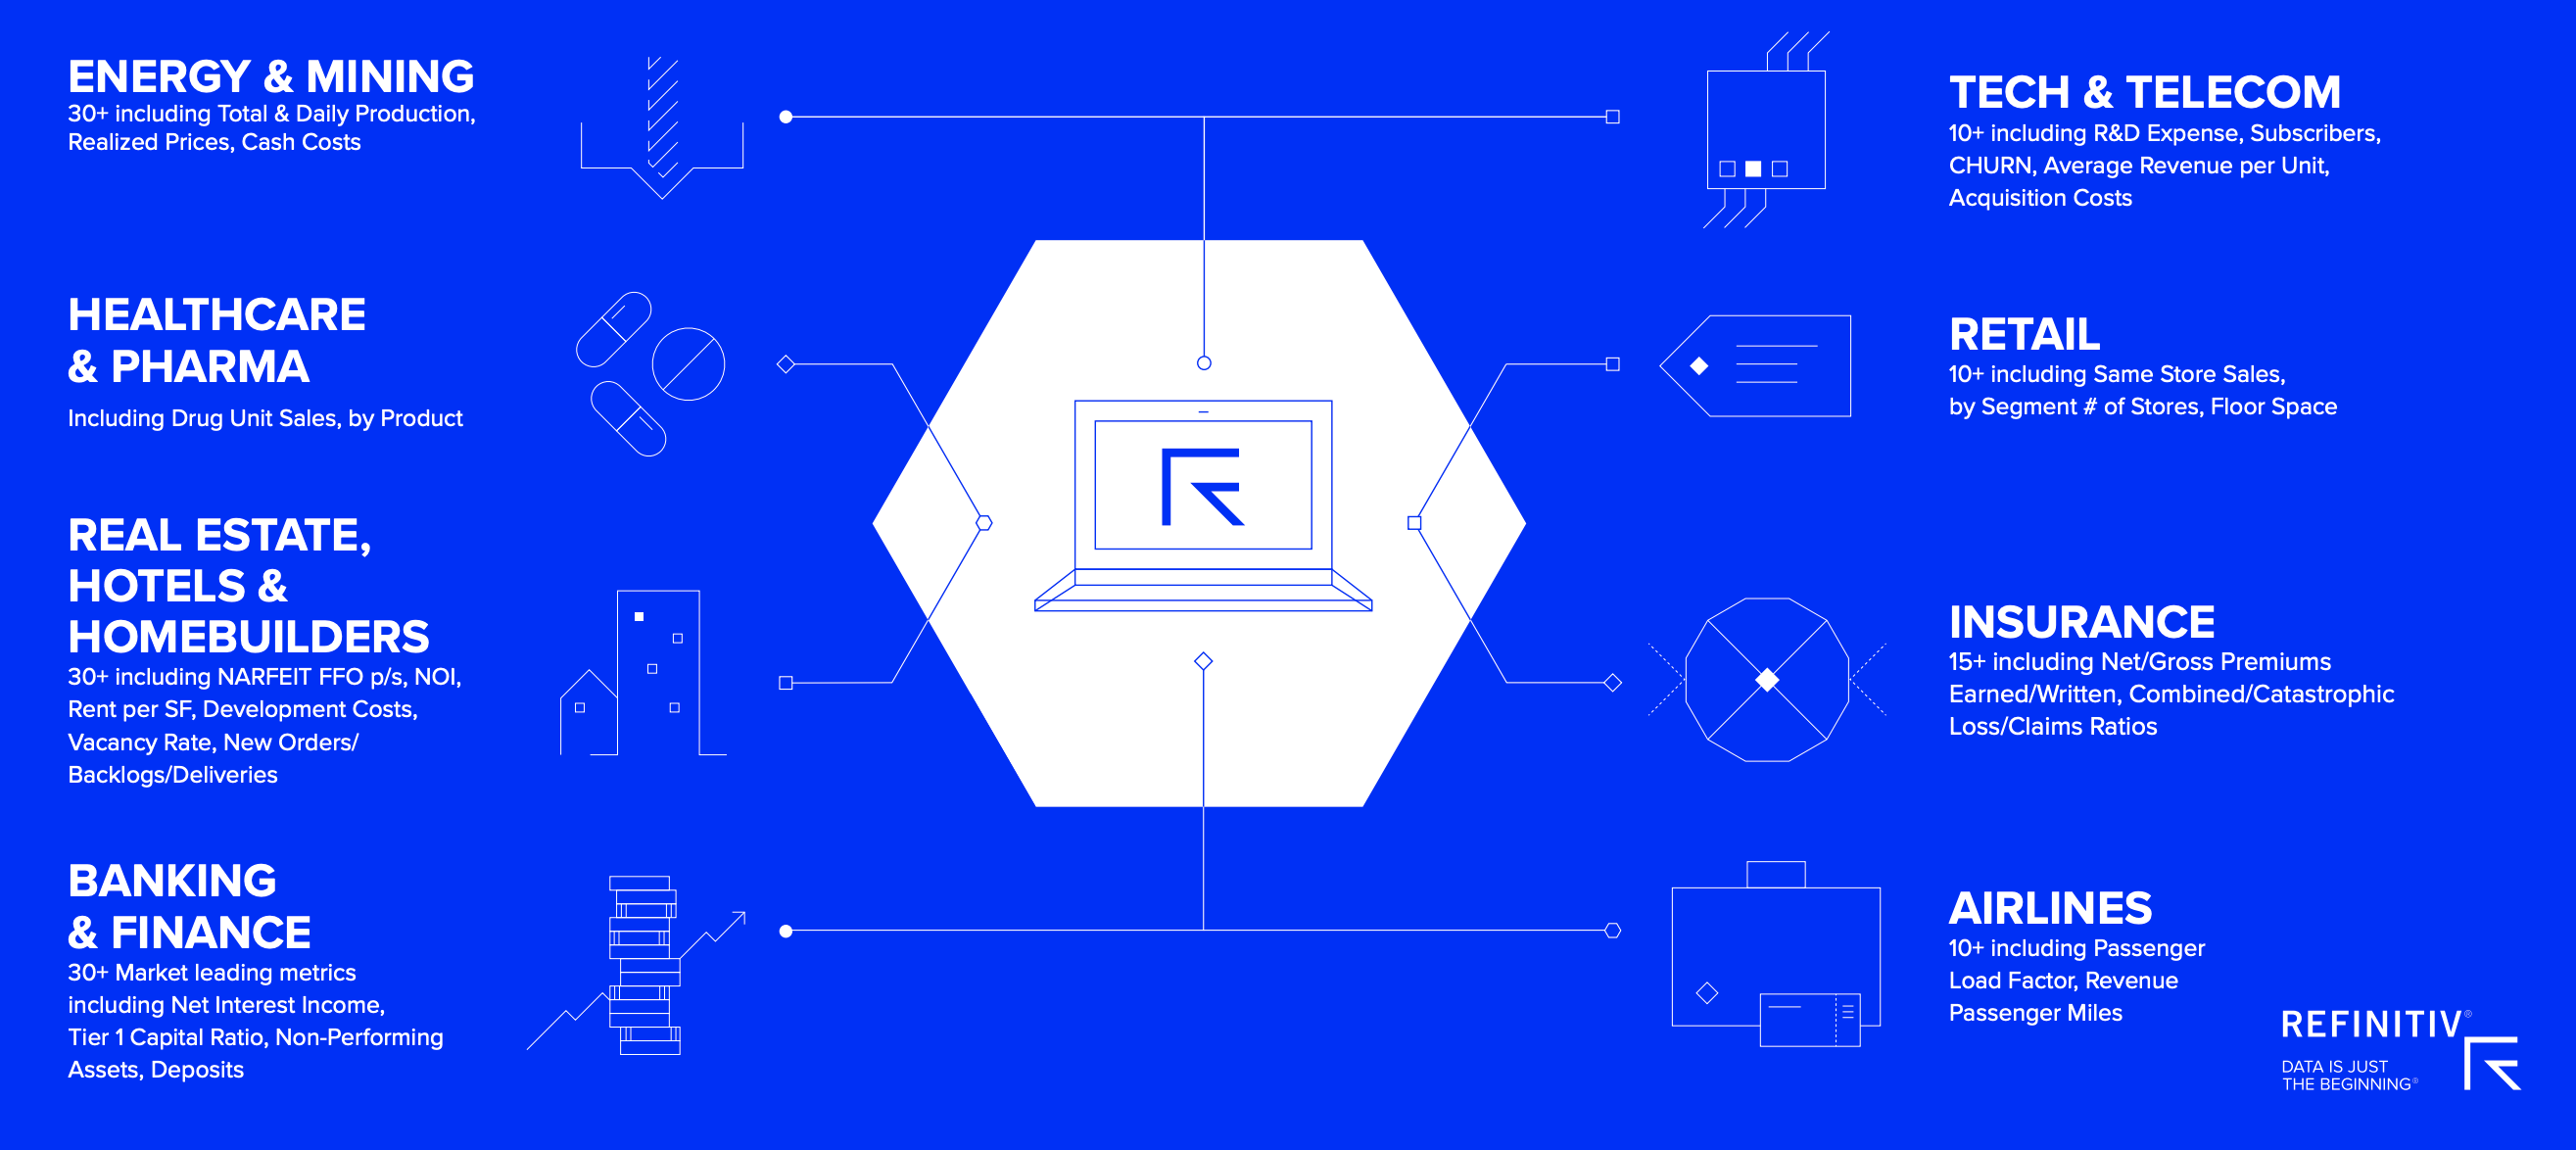

\- So lets have a look at how we can get individual analyst estimates for a stock - here we just look at Revenue.

In [7]:
df4 = rd.get_data(['VOD.L'], ['TR.RevenueEstValue(Period=FY1).date',
                              'TR.RevenueEstValue(Period=FY1).brokername',
                              'TR.RevenueEstValue(Period=FY1).analystname',
                              'TR.RevenueEstValue(Period=FY1).analystcode',
                              'TR.RevenueEstValue(Period=FY1)'])

df4

,Instrument,Date,Broker Name,Analyst Name,Analyst Code,Revenue - Broker Estimate
0,VOD.L,2024-06-19 05:10:00,DEUTSCHE BANK,"Grindle, Robert",4AIT,37073000000
1,VOD.L,2024-02-19 04:35:00,GOLDMAN SACHS,"Lee, Andrew",FG3,44218458000
2,VOD.L,2023-11-08 10:13:00,REDBURN ATLANTIC,"Malcolm, Steve",7R4V,42774920000
3,VOD.L,2024-06-10 00:26:00,JPMORGAN,"Dattani, Akhil",3MBD,37416000000
4,VOD.L,2023-08-07 05:24:00,LANDESBANK BADEN-WUERTTEMBERG,"Deuscher, Bettina",4O3B,43439000000
5,VOD.L,2024-05-17 04:00:00,UBS,"Tang, Polo",4Y98,37585408000
6,VOD.L,2024-06-24 06:10:00,BERENBERG,"Murdock-Smith, Carl",7K6U,37769000000
7,VOD.L,2024-04-03 14:27:00,"MORNINGSTAR, INC.","Correonero, Javier",7WZ3,40573000000
8,VOD.L,2024-06-14 23:46:00,CITI,"He, Siyi",7L54,37323300000
9,VOD.L,2024-05-14 18:53:00,NEXTGEN RESEARCH LTD,"Funnell, Justin",87UJ,36671000000


\- Expanded industry metrics - this time for Tech and Telecom - using Verizon. Note these expanded metrics will not be available for all geographies.

In [8]:
df5 = rd.get_data(['VZ'], ['TR.Subscribers.date', 'TR.Subscribers', 'TR.SubscribersBrokerName',
                           'TR.NetSubscriberAdds.date', 'TR.NetSubscriberAdds', 'TR.NetSubscriberAddsBrokerName',
                           'TR.AvgRevPerUnitEstValue.date', 'TR.AvgRevPerUnitEstValue', 'TR.AvgRevPerUnitEstBrokerName',
                           'TR.ChurnpctEstValue.date', 'TR.ChurnpctEstValue', 'TR.ChurnpctEstBrokerName'],
                  {'Period': 'FY1', 'SDate': '-200', 'EDate': '0', 'Frq': 'D'})
df5.head()

,Instrument,Date,No. Of Subscribers / Users - Broker Estimate,Broker Name,Date,Net Subscriber Additions - Broker Estimate,Broker Name,Date,Avg Revenue Per Unit / User - Broker Estimate,Broker Name,Date,Churn Percentage - Broker Estimate,Broker Name
0,VZ,2023-07-28 00:17:00,<NA>,MOFFETTNATHANSON,2023-07-25 16:45:00,2070000,"WELLS FARGO SECURITIES, LLC",2023-09-22 06:08:00,<NA>,DEUTSCHE BANK,2023-04-27 23:20:00,<NA>,RBC CAPITAL MARKETS
1,VZ,2023-07-25 16:20:00,145476000,JPMORGAN,2023-07-25 18:10:00,2000000,"OPPENHEIMER & CO., INC.",2023-08-22 06:11:00,44.1,"OPPENHEIMER & CO., INC.",2023-04-27 23:20:00,<NA>,MOFFETTNATHANSON
2,VZ,2023-07-28 00:17:00,125517000,BARCLAYS,2023-06-06 06:04:00,<NA>,DEUTSCHE BANK,2023-09-22 06:08:00,<NA>,MOFFETTNATHANSON,2022-07-25 06:41:00,1.02,"OPPENHEIMER & CO., INC."
3,VZ,2023-07-28 00:17:00,<NA>,MOFFETTNATHANSON,2023-06-06 06:04:00,1550000,MOFFETTNATHANSON,2023-09-22 06:08:00,<NA>,DEUTSCHE BANK,2023-04-25 17:09:00,1.07,"WELLS FARGO SECURITIES, LLC"
4,VZ,2023-07-28 00:17:00,125517000,BARCLAYS,2023-06-06 06:04:00,<NA>,DEUTSCHE BANK,2023-09-22 06:08:00,<NA>,MOFFETTNATHANSON,2023-04-27 23:20:00,<NA>,DEUTSCHE BANK


### Consensus Estimates

\- With so many different analyst opinions - consensus estimates developed to capture mean of all analysts

\- Our I/B/E/S (Institutional Brokers Estimates System) is the industry standard, founded in 1976

\- Offers coverage for 22K active companies across 90 countries from over 18K analysts

\- Not all analysts report on all measures - so number of included estimates can vary across measure

\- Some estimates are not included due to staleness

\- Can check variation estimates are by looking at Estimate High, Low and Median

\- Great thing is we can track these consensus estimates on a daily basis 

\- Clustering / herd behaviour - can change these metrics rapidly in some cases in other cases its slow

\- To see the impact on shareprice of VOD.L - it is easy just to add a closing shareprice for the last 2000 days.

In [9]:
df6 = rd.get_data(['VOD.L'], ['TR.RevenueMean(Period=FY1).calcdate',
                              'TR.RevenueMean(Period=FY1)',
                              'TR.RevenueNumIncEstimates(Period=FY1)',
                              'TR.GrossIncomeMean(Period=FY1)',
                              'TR.GrossIncomeNumIncEstimates(Period=FY1)',
                              'TR.PreTaxProfitMean(Period=FY1)',
                              'TR.PreTaxProfitNumIncEstimates(Period=FY1)',
                              'TR.NetProfitMean(Period=FY1)',
                              'TR.NetProfitNumIncEstimates(Period=FY1)',
                              'TR.EPSMean(Period=FY1)',
                              'TR.EPSNumIncEstimates(Period=FY1)',
                              'TR.DPSMean(Period=FY1)',
                              'TR.DPSNumIncEstimates(Period=FY1)',
                              'TR.CLOSEPRICE(Adjusted=1)'],
                  {'SDate': '-2000', 'EDate': '0', 'Frq': 'D'})

df6.index = pd.to_datetime(df6['Calc Date'])
df6

,Instrument,Calc Date,Revenue - Mean,Revenue - Number of Included Estimates,Gross Income - Mean,Gross Income - Number of Included Estimates,Pre-Tax Profit - Mean,Pre-Tax Profit - Number of Included Estimates,Net Income - Mean,Net Income - Number of Included Estimates,Earnings Per Share - Mean,Earnings Per Share - Number of Included Estimates,Dividend Per Share - Mean,Dividend Per Share - Number of Included Estimates,Close Price
Calc Date,,,,,,,,,,,,,,,
2016-07-28,VOD.L,2016-07-28,55109896170,24,28552245350,3,2891363430,16,1886803280,19,0.07335,24,0.15387,27,229.75
2016-07-29,VOD.L,2016-07-29,55109896170,24,28552245350,3,2891363430,16,1886803280,19,0.07335,24,0.15387,27,229.55
2016-08-01,VOD.L,2016-08-01,55109896170,24,28552245350,3,2891363430,16,1886803280,19,0.07335,24,0.15387,27,229.95
2016-08-02,VOD.L,2016-08-02,55109896170,24,28552245350,3,2891363430,16,1886803280,19,0.07335,24,0.15387,27,226.95
2016-08-03,VOD.L,2016-08-03,55109896170,24,28552245350,3,2891363430,16,1886803280,19,0.07335,24,0.15387,27,230.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25,VOD.L,2024-06-25,38722942710,17,13389000000,1,3047693270,15,2211587000,14,0.07967,18,0.06056,18,70.66
2024-06-26,VOD.L,2024-06-26,38722942710,17,13389000000,1,3047693270,15,2211587000,14,0.07967,18,0.06056,18,69.72
2024-06-27,VOD.L,2024-06-27,38722942710,17,13389000000,1,3047693270,15,2211587000,14,0.07967,18,0.06056,18,69.42


\- Easy to visualise any of these components impacts on shareprice

array([<AxesSubplot:xlabel='Calc Date'>, <AxesSubplot:xlabel='Calc Date'>],
      dtype=object)

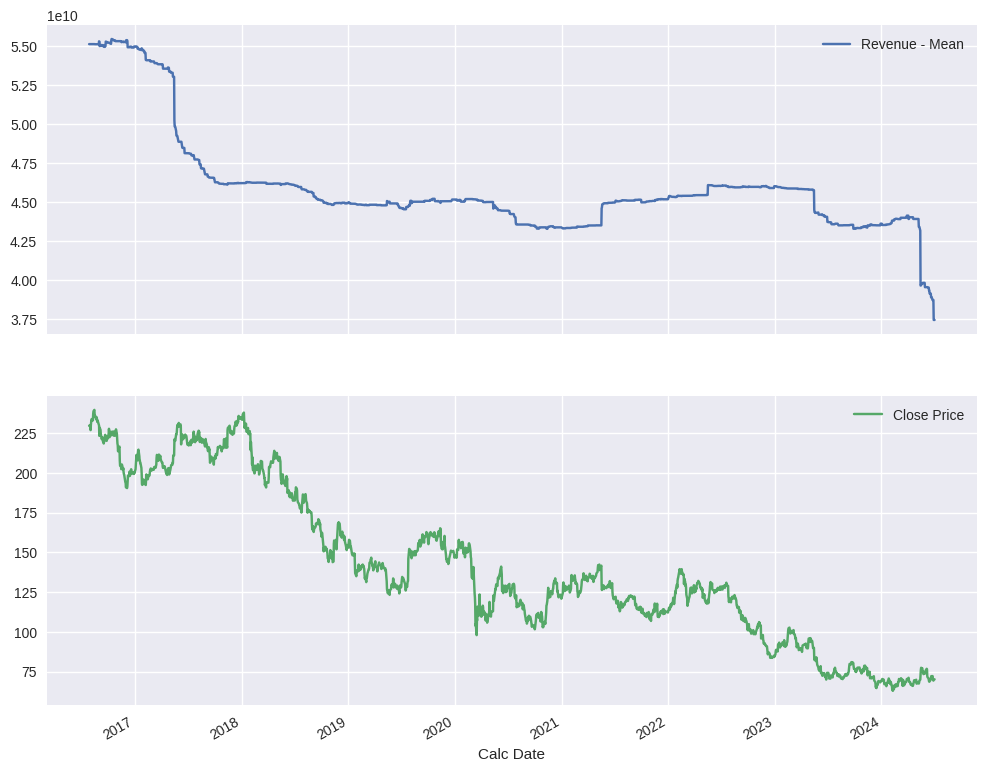

In [10]:
df6[['Revenue - Mean', 'Close Price']].plot(subplots=True, figsize=(12, 10))

In [11]:
df6[['Revenue - Mean', 'Close Price']].corr()

,Revenue - Mean,Close Price
Revenue - Mean,1.000000,0.669373
Close Price,0.669373,1.000000


### Starmine SmartEstimates

\- Go a step further by trying to weight more successful (in terms of accuracy) analyst opinions more highly

\- More weight is also given to more recent updates whilst those that are stale are completely dropped

\- Lots of papers written about validity and transparency of Starmine SmartEstimates

\- Lets get a selection of these SmartEstimates for 200 days and chart

In [12]:
df7 = rd.get_data(['VOD.L'], ['TR.RevenueMean(Period=FY1).date',
                              'TR.RevenueSmartEst(Period=FY1)',
                              'TR.RevenueSENumIncEst(Period=FY1)',
                              'TR.GrossIncomeSmartEst(Period=FY1)',
                              'TR.GrossIncomeSENumIncEst(Period=FY1)',
                              'TR.PreTaxProfitSmartEst(Period=FY1)',
                              'TR.PreTaxProfitSENumIncEst(Period=FY1)',
                              'TR.NetprofitSmartEst(Period=FY1)',
                              'TR.NetProfitSENumIncEst(Period=FY1)',
                              'TR.EpsSmartEst(Period=FY1)',
                              'TR.EpsSENumIncEst(Period=FY1)',
                              'TR.DPSSmartEst(Period=FY1)',
                              'TR.DPSSENumIncEst(Period=FY1)',
                              'TR.CLOSEPRICE(Adjusted=1)'],
                  {'SDate': '-200', 'EDate': '0'})

df7.index = pd.to_datetime(df7['Date'])
df7

,Instrument,Date,Revenue - SmartEstimate®,Revenue - SmartEstimate Num of Included Estimates,Gross Income - SmartEstimate®,Gross Income - SENum Inc Ests,Pre-Tax Profit - SmartEstimate®,Pre-Tax Profit - SmartEstimate Num of Included Estimates,Net Income - SmartEstimate®,Net Income - SmarteEstimate Num of Included Estimates,Earnings Per Share - SmartEstimate®,Earnings Per Share - SmartEstimate Num of Included Estimates,Dividend Per Share - SmartEstimate®,Dividend Per Share - SmartEstimate Num of Included Estimates,Close Price
Date,,,,,,,,,,,,,,,
2023-09-14,VOD.L,2023-09-14,43465220180,17,16549187790,2,3472744860,12,2421872680,15,0.08307,13,0.07487,9,79.94
2023-09-14,VOD.L,2023-09-14,43465220180,17,16549187790,2,3472744860,12,2434187550,14,0.08307,13,0.07487,9,79.81
2023-09-18,VOD.L,2023-09-18,43467558860,17,16362066860,2,3475657060,12,2434117780,14,0.08314,13,0.0711,9,79.43
2023-09-18,VOD.L,2023-09-18,43467558860,17,16362066860,2,3475657060,12,2434117780,14,0.08314,13,0.0711,9,80.07
2023-09-18,VOD.L,2023-09-18,43467558860,17,16362066860,2,3475657060,12,2434117780,14,0.08314,13,0.0711,9,81.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,VOD.L,2024-06-24,37298537270,7,13389000000,1,2817716600,7,2189668190,10,0.08086,11,0.05385,15,70.66
2024-06-24,VOD.L,2024-06-24,37298537270,7,13389000000,1,2817716600,7,2189668190,10,0.08086,11,0.05385,15,69.72
2024-06-24,VOD.L,2024-06-24,37298537270,7,13389000000,1,2817716600,7,2189668190,10,0.08086,11,0.05385,15,69.42


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

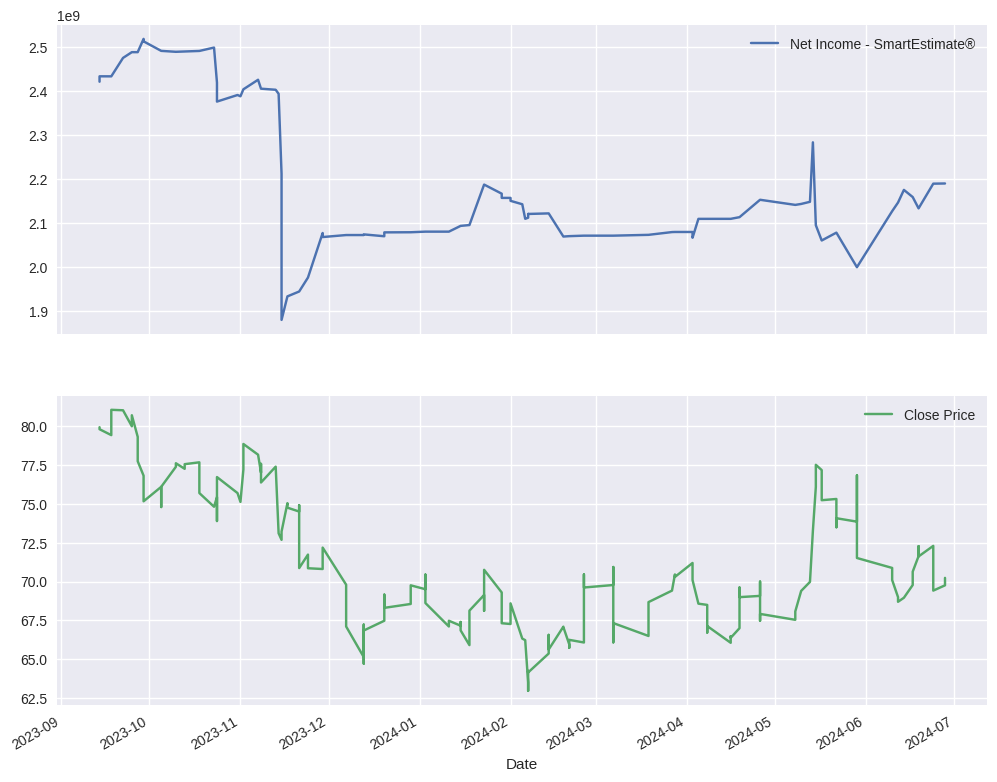

In [13]:
df7[['Net Income - SmartEstimate®', 'Close Price']
    ].plot(subplots=True, figsize=(12, 10))

In [14]:
df7[['Net Income - SmartEstimate®', 'Close Price']].corr()

,Net Income - SmartEstimate®,Close Price
Net Income - SmartEstimate®,1.000000,0.642307
Close Price,0.642307,1.000000


### Discounted Cash Flow
    
\- Many ways to approach this sort of valuation task as evidenced by number of textbooks on the subject

\- Instead of us forecasting free cash flow ourselves - we use I/B/E/S consensus - typically these go out 4 years or so 

\- After this period, forecasting becomes more challenging - but we need to capture what is known as a terminal value for the remaining cash flows based on some exit multiple

\- We take the most recent EV / FCF multiple and assign that to our last forecasted cash flow number to get our terminal value

\- So lets get some data, first some stock-type data

In [15]:
df8 = rd.get_data('VOD.L', ['TR.F.DebtTot', 'TR.WACC',
                  'TR.F.ComShrOutsTot(Period=FY0)', 'TR.EVtoFCFSmartEst(Period=FY1)'])
df8

,Instrument,Debt - Total,"Weighted Average Cost of Capital, (%)",Common Shares - Outstanding - Total,EV / Free Cash Flow (SmartEstimate ®)
0,VOD.L,56987000000,6.087785,27080121854,23.291924


\- Next we will get our IBES consensus free cash flow forecasts going out 4 fiscal years. I also include the most recent actual value at the start. 

In [16]:
fcf = rd.get_data('VOD.L', ['TR.FCFMean(Period=FY0)', 'TR.FCFMean(Period=FY1)', 'TR.FCFMean(Period=FY2)',
                            'TR.FCFMean(Period=FY3)', 'TR.FCFMean(Period=FY4)'])
fcf.columns = ['RIC', 'FCF-FY0', 'FCF-FY1', 'FCF-FY2', 'FCF-FY3', 'FCF-FY4']
fcf

,RIC,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4
0,VOD.L,2797234870,3855565250,3007795020,3199646570,3213494120


\- Next, calculate the net present value (df8['Weighted Average Cost of Capital, (%)'][0]/100) of these cash flows using WACC as the discount rate.

In [32]:
dfcf = npf.npv(df8['Weighted Average Cost of Capital, (%)'][0]/100, fcf.iloc[0, 2:6].dropna(how=any).tolist())
dfcf

12225142287.605186

\- Now calculate our terminal value using the exit multiple we identified - in this case Enterprise Value / Free Cash Flow multiple, and apply this to the last Free Cash Flow forecast (FY4).

In [33]:
tv_exit = df8['EV / Free Cash Flow (SmartEstimate ®)'][0] * \
    fcf.iloc[0, 2:5].dropna(how=any)[-1]
tv_exit

74525926282.17845

\- We now set our flow value to be the sum of our discounted cash flow plus our terminal value. 

In [34]:
flo_val = dfcf + tv_exit
flo_val

86751068569.78363

\- Subtract the debt portion from the enterprise value so we are left with our Equity portion - which we can then divide by shares outstanding to get our valuation per share.

In [35]:
model_price = (flo_val - df8['Debt - Total']) / \
    df8['Common Shares - Outstanding - Total']
model_price

0    1.099111
dtype: Float64

\- As this is a UK share we need to multiply the equity value (which is in pounds) to pence so we can compare it to the quoted shareprice.

In [36]:
model_price*100

0    109.911132
dtype: Float64

\- Now we can just compare it to the most recent closing price. 

In [37]:
df9 = rd.get_data('VOD.L', 'CF_CLOSE')
df9

,Instrument,CF_CLOSE
0,VOD.L,70.24


### Peer Group Comparison
    
\- Refinitiv Data Libraries API provide neat Peers function - retrieve list of Global Peer RICs 

\- Easy to scale an intrinsic valuation to a relative valuation or competitor analysis
    
\- We will use our previous DCF - but you can of course replace or add your own measures such as PER, PCF, PTS, EV/Ebitda, Dividend Yield etc

\- When scaling you may need to handle missing data etc so dealing with exceptions is part of process - however I just drop any problem candidates as we have enough peers
    
\- Cautionary note: no two companies are identical, differences in balance sheet structures, asset holdings, efficiencies, innovation, performance stability and many other factors all play major roles in divergent outcomes of companies. Also different economic phases can effect companies differently eg NIRP/ZIRP could keep zombie companies alive for longer than normal interest rate environments would tolerate. DCF is just one tool in our armoury.

\- Get all data we need for target and its peers -  I also drop any peers with NAs - Please enter a valid RIC in the cell below


In [38]:
ric = widgets.Text(
    value='',
    placeholder='Type something',
    description='RIC:',
    disabled=False
)

box_layout = Layout(display='flex',
                    flex_flow='row wrap',
                    align_items='stretch',
                    border='solid',
                    width='100%')

items = [ric]
box = Box(children=items, layout=box_layout)

box


Box(children=(Text(value='', description='RIC:', placeholder='Type something'),), layout=Layout(align_items='s…

In [39]:
_peers = Peers(ric.value)
peers = rd.get_data([ric.value, *_peers], fields=['TR.CompanyName', 'TR.ExchangeCountry', 'TR.F.DebtTot', 'TR.WACC', 'TR.F.ComShrOutsTot(Period=FY0)',
                                                  'TR.EVtoFCFSmartEst(Period=FY1)', 'TR.FCFMean(Period=FY0)',
                                                  'TR.FCFMean(Period=FY1)', 'TR.FCFMean(Period=FY2)',
                                                  'TR.FCFMean(Period=FY3)', 'TR.FCFMean(Period=FY4)', 'TR.PRICECLOSE'])
peers.columns = ['RIC', 'Name', 'Country', 'Debt - Total', 'WACC %', 'Shs Out',
                 'EV/FCF', 'FCF-FY0', 'FCF-FY1', 'FCF-FY2', 'FCF-FY3', 'FCF-FY4', 'Close Price']
peers.dropna(axis=0, how='any', inplace=True)
peers['EV/FCF'] = peers['EV/FCF'].astype(float)
peers.reset_index(drop=True, inplace=True)
peers

,RIC,Name,Country,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price
0,MSFT.O,Microsoft Corp,United States of America,64304000000,6.897783,7432000000,48.135237,58865880530,69492349570,77637038260,92861944000,107554300000,456.73
1,CRM.N,Salesforce Inc,United States of America,10400000000,7.94933,971000000,20.313447,8480575070,11817213270,13355098140,15267485330,19827000000,256.21
2,ORCL.N,Oracle Corp,United States of America,86869000000,6.948249,2755000000,49.978388,11437925000,9683540590,13314315290,17281782500,24890000000,143.09
3,ADBE.OQ,Adobe Inc,United States of America,3634000000,7.994902,455000000,31.735324,7716317940,7671783110,9429576000,10176000000,8675000000,560.01
4,META.OQ,Meta Platforms Inc,United States of America,19075000000,7.808577,2561000000,28.200513,38098416670,44298792110,49245243160,56826535000,70990260000,504.68
5,AMZN.OQ,Amazon.com Inc,United States of America,85788000000,7.556602,10383000000,36.357658,35521821430,56973480530,74795932380,96880828330,111471055560,197.2
6,AAPL.OQ,Apple Inc,United States of America,112112000000,7.811609,15550061000,31.501007,101602374250,106542595000,118696284390,129214366250,223211000000,216.75
7,IBM.N,International Business Machines Corp,United States of America,56547000000,5.888747,915013646,16.707261,10462650000,11947995000,12474320000,13300020000,13660480000,175.1
8,OKTA.OQ,Okta Inc,United States of America,1154000000,7.126417,167126000,26.760725,418562890,548170730,648319320,764740000,1001133330,94.55
9,SAPG.DE,SAP SE,Germany,8791000000,8.443319,1167229056,60.500760,5003327330,3677324550,8272540000,9386681820,6078166500,185.68


\- Conduct DCF for all companies and compare closing price with model price

In [47]:
peers['m_price'] = np.nan
peers['method'] = np.nan
peers['prem/disc'] = np.nan

for i, peer in enumerate(peers['RIC']):
    multiple = peers.iloc[i][7]

    for col in range(12, 9, -1):
        if pd.isnull(peers.iloc[i][col]):
            pass
        else:
            last = col
            break
    dfcf = npf.npv(peers.iloc[i][4]/100, peers.iloc[i, 8:last].tolist())
    if not pd.isna(dfcf):
        if dfcf > 0:
            if pd.isnull(multiple) or multiple == "NaN":
                tv_exit = (peers.iloc[i][last] * (1 + 0.1)
                           ) / ((peers.iloc[i]['WACC %']) - 1)
                peers['method'][i] = 'perpetual growth'
            elif peers.iloc[i][last] < 0:
                tv_exit = multiple * peers.iloc[i, 9:last].mean()
                peers['method'][i] = 'multiple - fcfAvg'
            else:
                tv_exit = multiple * peers.iloc[i][last]
                peers['method'][i] = 'multiple'

            flo_val = dfcf + tv_exit
            model_price = (
                flo_val - peers.iloc[i]['Debt - Total']) / peers.iloc[i]['Shs Out']
            peers['m_price'][i] = model_price

            if peers.iloc[i][2] == 'United Kingdom' or peers.iloc[i][2] == 'South Africa':
                peers['m_price'][i] = peers['m_price'][i]*100

            if peers['m_price'][i] <= 0:
                peers['m_price'][i] = np.nan

            if not pd.isnull(peers.iloc[i]['Close Price']):
                if not pd.isnull(peers.iloc[i]['m_price']):
                    peers['prem/disc'][i] = (peers.iloc[i]['Close Price'] /
                                             peers.iloc[i]['m_price']-1) * 100
    else:
        peers.iloc[i]['m_price'] = np.nan


In [48]:
peers.dropna(axis=0, how='any', inplace=True)
peers.reset_index(drop=True, inplace=True)
peers

,RIC,Name,Country,Debt - Total,WACC %,Shs Out,EV/FCF,FCF-FY0,FCF-FY1,FCF-FY2,FCF-FY3,FCF-FY4,Close Price,m_price,method,prem/disc
0,MSFT.O,Microsoft Corp,United States of America,64304000000,6.897783,7432000000,48.135237,58865880530,69492349570,77637038260,92861944000,107554300000,456.73,3.650826e+03,multiple,-87.489682
1,CRM.N,Salesforce Inc,United States of America,10400000000,7.94933,971000000,20.313447,8480575070,11817213270,13355098140,15267485330,19827000000,256.21,2.281627e+03,multiple,-88.770734
2,ORCL.N,Oracle Corp,United States of America,86869000000,6.948249,2755000000,49.978388,11437925000,9683540590,13314315290,17281782500,24890000000,143.09,5.834384e+02,multiple,-75.474705
3,ADBE.OQ,Adobe Inc,United States of America,3634000000,7.994902,455000000,31.735324,7716317940,7671783110,9429576000,10176000000,8675000000,560.01,9.559554e+03,multiple,-94.141882
4,META.OQ,Meta Platforms Inc,United States of America,19075000000,7.808577,2561000000,28.200513,38098416670,44298792110,49245243160,56826535000,70990260000,504.68,7.576712e+03,multiple,-93.339063
5,AMZN.OQ,Amazon.com Inc,United States of America,85788000000,7.556602,10383000000,36.357658,35521821430,56973480530,74795932380,96880828330,111471055560,197.2,6.952676e+02,multiple,-71.636821
6,AAPL.OQ,Apple Inc,United States of America,112112000000,7.811609,15550061000,31.501007,101602374250,106542595000,118696284390,129214366250,223211000000,216.75,1.441546e+03,multiple,-84.964062
7,IBM.N,International Business Machines Corp,United States of America,56547000000,5.888747,915013646,16.707261,10462650000,11947995000,12474320000,13300020000,13660480000,175.1,1.991838e+03,multiple,-91.209126
8,OKTA.OQ,Okta Inc,United States of America,1154000000,7.126417,167126000,26.760725,418562890,548170730,648319320,764740000,1001133330,94.55,2.456541e+02,multiple,-61.510928
9,SAPG.DE,SAP SE,Germany,8791000000,8.443319,1167229056,60.500760,5003327330,3677324550,8272540000,9386681820,6078166500,185.68,8.089934e+02,multiple,-77.048020


### Relative Valuation
    
\- Now we can place VOD.L in a DCF relative valuation space amongst its peers

\- Can easily adapt to all manner of factors and metrics

\- Outlier handling important - xlim or ylim parameters useful or explicit exclusion may also be required - examples of both. If the chart has outliers try uncommenting the xlim and ylim parameters below and re-running the cell

\- Linear regression up first 

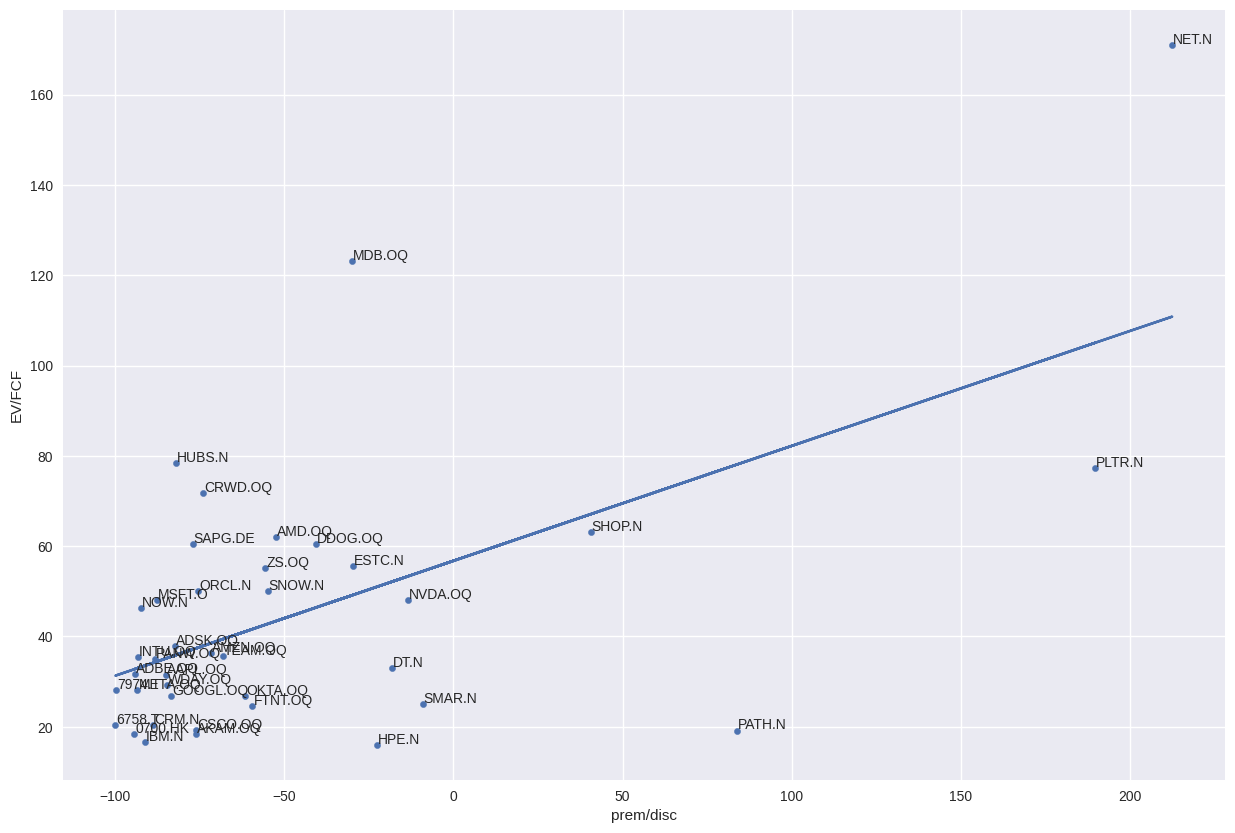

In [49]:
ax1 = peers.plot.scatter(x='prem/disc', y='EV/FCF', figsize=(15, 10))

for i, ric in enumerate(peers['RIC']):
    if not pd.isnull(peers['prem/disc'][i]):
        if not pd.isnull(peers['EV/FCF'][i]):
            # ax1.set_ylim(0,100) if you have outliers user these parameters
            # ax1.set_xlim(-100, 100) if you have outliers user these parameter
            ax1.text(x=peers['prem/disc'][i]+0.3,
                     y=peers['EV/FCF'][i]+0.3, s=peers['RIC'][i])

X, Y = peers['prem/disc'].values.reshape(-1,
                                         1), peers['EV/FCF'].values.reshape(-1, 1)
ax1.plot(X, LinearRegression().fit(X, Y).predict(X))


### Clustering
    
\- Try to extend our relative valuation study to group similar companies into clusters. We saw previously there seemed to be a steep negative relationship between our two variables

\- However are there perhaps more useful ways of classifying this distribution eg Do companies that have very high EV/FCF multiples really belong in the same group as those that have low or more reasonable EV/FCF? 

\- Thankfully yes - here we use an unsupervised algorithm - the algo generates the group labels from the observed data

\- Many ways of doing this - we look at 2 - KMeans clustering and Gaussian Mixture Models, popular in the literature. 

\- I am interested in classifying the bulk of observations so I more formally remove outliers 

In [50]:
# You may need to change these to what seems sensible for each universe
exoutlier = peers[(peers['prem/disc'] < 75) & (peers['EV/FCF'] < 60)]
X = exoutlier[['prem/disc', 'EV/FCF']].values

### KMeans Clustering

\- Determine optimal amount of clusters using elbow chart. Conduct KMeans 10 times and graph the intertia_ property ==> tells us 2-3 clusters is optimal
    
\- Use n_clusters = 3 to generate classification and plot it 

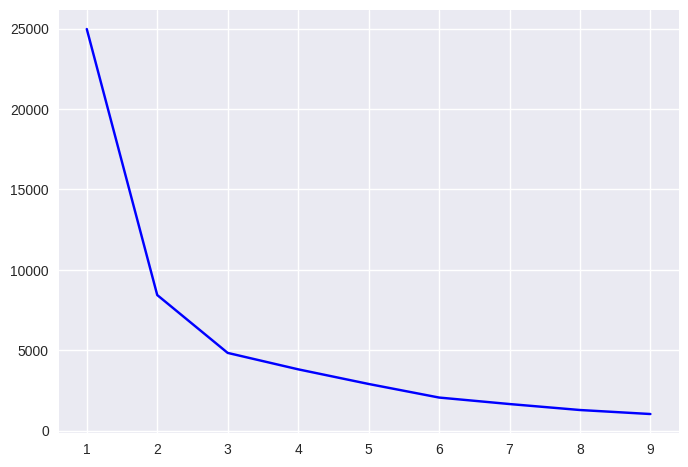

In [51]:
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)

plt.pyplot.plot(K, inertia, 'bx-')


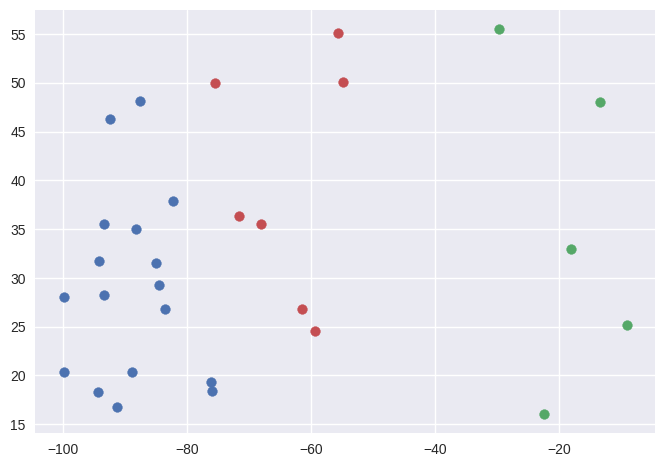

In [52]:
km = KMeans(n_clusters=3)
km.fit(X)
pred = km.predict(X)
clusters = unique(pred)
for cluster in clusters:
    row = where(pred == cluster)
    plt.pyplot.scatter(X[row, 0], X[row, 1])
plt.pyplot.show()


### Gaussian Mixture Models

\- Same way use n_components=3 and generate cluster groupings

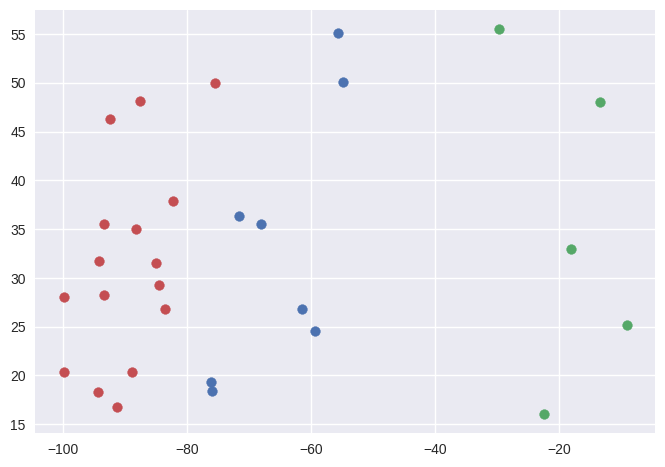

In [53]:
model = GaussianMixture(n_components=3)
model.fit(X)
pred = model.predict(X)
clusters = unique(pred)
for cluster in clusters:
    row = where(pred == cluster)
    plt.pyplot.scatter(X[row, 0], X[row, 1])
plt.pyplot.show()

\- In this case simple linear regression works rather well

\- Some merit in groupings suggested by KM and GMM

\- Which to use could depend on use case but can provide further information for your quantamental analysis

In [34]:
rd.close_session()

**Further Resources for Refinitiv Data Libraries API on Developer Community Portal**

* [Overview](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) 
* [Quick Start ](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start)
* [Documentation](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/documentation)
* [Tutorials](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/tutorials)
* [Q&A Forums](https://community.developers.refinitiv.com/spaces/321/index.html)